For this analysis I will do a Direct Multi-step forecast for the next 15/30 days.

I will test a variety of models that will run for each Nth day to find out what is the optimal model. There will be no parameter tuning.

In [1]:
import pyodbc
import sqlalchemy
import pandas as pd
import numpy as np
import json
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

In [2]:
# server connection

with open(f'/Users/terrill/Documents/work/stuff/spy_trend/sql_server_info_equities.txt', 'r') as f:
    line = f.readline().split(',')
name, user, password = line[0], line[3], line[4]

sqlalchemy.create_engine(f'mssql+pyodbc://{user}:{password}@{name}')
%load_ext sql
%sql mssql+pyodbc://$user:$password@$name
%config SqlMagic.displaycon = False

<h5>Cleaning up Yahoo data</h5>

In [3]:
def clean_yahoo_df(df, ticker):
    df.drop(['HighPrice','LowPrice','OpenPrice'], axis=1, inplace=True)
    df = df.astype({'ClosePrice': 'float'})
    df['ClosePrice'] = df['ClosePrice'].round(2)
    #df['Volume'] = df['Volume'].astype('int32')
    df.rename(columns={'Volume': f'{ticker}_Volume', 'ClosePrice': ticker}, inplace=True)
    df.set_index('Date', inplace=True)
    
    return df

In [4]:
%%capture

main_df = %sql select * from equities.dbo.spy order by date

main_df = clean_yahoo_df(main_df.DataFrame(), 'SPY')

In [5]:
main_df.tail()

,SPY,SPY_Volume
Date,,
2020-07-31,326.52,85210800
2020-08-03,328.79,53077900
2020-08-04,330.06,41917900
2020-08-05,332.11,42866400
2020-08-06,334.33,43516400


A few economic indicators are updated weekly, monthly, etc. Some of those days are on the weekend when equity markets are not opened. For that, we will have to outer join those dataframes with the main dataframes, forward fill the NaN data, and remove weekend dates. Below is the list of SPY dates that will be used later.

In [6]:
spy_dates = list(main_df.index)

Below are all tickers pulled from Yahoo and saved locally. I will need to find a way to automate the refresh daily but for now will use the data I have to optimize the model.

Also note, for the individual sector ETFs, I will use Vanguard ETFs instead of SPDR even if SPY is an SPDR ETFs. Even though most of the SPDR ETFs are larger and more liquid I find the Vanguard ETFs more accurately reflects their respective idustries as the portfolios include small and mid caps. SPDR ETFs are heavily concentrated in stocks already included in SPY.

In [7]:
etfs = ['QQQ', 'IWM', 'TLT', 'IEF', 'VNQ', 'VGT', 'VHT', 'VFH', 'VCR', 'VIS', 'VDC', 'VPU', 'VDE', 'VAW', 'VOX']

futures = ['Crude_Oil_WTI']

In [8]:
%%capture

for ticker in etfs:
    query = %sql SELECT * FROM Equities.dbo.$ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

for ticker in futures:
    new_ticker = ticker.replace('=','_')
    query = %sql SELECT * FROM Futures.dbo.$new_ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

In [9]:
main_df.tail(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,VPU,VPU_Volume,VDE,VDE_Volume,VAW,VAW_Volume,VOX,VOX_Volume,Crude_Oil_WTI,Crude_Oil_WTI_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-04,330.06,41917900,270.38,24911300.0,150.79,20285000.0,171.57,9878900.0,123.06,3842000.0,...,132.65,480600.0,49.71,548700.0,130.32,178500.0,100.69,115400.0,41.70,451580.0
2020-08-05,332.11,42866400,271.05,21685900.0,153.79,18526900.0,170.07,6954100.0,122.65,2423700.0,...,131.07,249300.0,50.38,870300.0,132.60,97600.0,100.86,117100.0,42.19,491270.0
2020-08-06,334.33,43516400,274.64,27947100.0,153.73,18154100.0,171.02,9480700.0,122.79,2286500.0,...,131.83,155400.0,49.91,455100.0,131.97,65200.0,102.72,105200.0,41.95,359610.0


<h5>Other charts (Treasure bond yields, Libor rate, Mortgage rate, M1 & M2 money supply, VIX, DIX)</h5>
<br>
Data pulled from various sources.

In [10]:
# maybe include VVIX in the future?
# Notes:
# 30 year fixed mortgage rate is updated monthly (need may numbers)
# money supply data is updated weekly

economics_tickers = ['DFF', 'DGS10', 'DGS30', 'M1', 'M2', 'MORTGAGE15US', 'MORTGAGE30US',
                     'T10YIE', 'USD1MTD156N', 'USD6MTD156N', 'USD12MD156N']
economic_names = ['Fed_Funds_Rate', '10_yr_Treasury', '30_yr_Treasury', 'M1_Supply',
                  'M2_Supply', '15_yr_Mortgage', '30_yr_Mortgage', '10_yr_Inflation',
                  '1m_Libor', '3m_Libor', '12m_Libor']
# CPI data
# 'CPIAUCSL', 'CPI', 

forex = ['USD_JPY', 'USD_EUR', 'USD_CHF', 'USD_PLN', 'USD_CNY', 'USD_HUF', 'USD_RUB', 'USD_CAD',
         'USD_RON', 'USD_INR', 'USD_GBP', 'USD_AUD', 'USD_HKD', 'USD_SEK', 'USD_SGD', 'XAU_USD',
         'DXY']

vix = 'I_VIX'
dix = 'DIX'

In [11]:
%%capture

# economics data
for ticker, name in zip(economics_tickers, economic_names):
    query = %sql SELECT * FROM Economics.dbo.$ticker WHERE Date >= '1993-01-01' ORDER BY date
    temp_df = query.DataFrame()
    temp_df.set_index('Date', inplace=True)
    temp_df.rename(columns={temp_df.columns[0]: name}, inplace=True)
    if ticker in ['M1', 'M2']:
        temp_df *= 1000000000
    temp_df = temp_df.astype({name: 'float'})
    main_df = main_df.join(temp_df, how='outer')

# forex
for ticker in forex:
    query = %sql SELECT * FROM Forex.dbo.$ticker WHERE Date >= '1993-01-01' ORDER BY date
    temp_df = query.DataFrame()
    temp_df.drop(['OpenPrice', 'HighPrice', 'LowPrice'], axis=1, inplace=True)
    temp_df = temp_df.astype({'ClosePrice': 'float'})
    temp_df['ClosePrice'] = temp_df['ClosePrice'].round(2)
    temp_df.set_index('Date', inplace=True)
    temp_df.rename(columns={'ClosePrice': ticker}, inplace=True)
    main_df = main_df.join(temp_df, how='left')

# vix
query = %sql SELECT * FROM Equities.dbo.I_VIX WHERE Date >= '1993-01-01' ORDER BY date
temp_df = query.DataFrame()
temp_df.drop(['HighPrice', 'LowPrice', 'OpenPrice'], axis=1, inplace=True)
temp_df = temp_df.astype({'ClosePrice': 'float'})
temp_df['ClosePrice'] = temp_df['ClosePrice'].round(2)
temp_df.set_index('Date', inplace=True)
temp_df.rename(columns={'ClosePrice': 'VIX'}, inplace=True)
main_df = main_df.join(temp_df, how='left')

# # dix (leaving this out for now)
# query = %sql SELECT * FROM Equities.dbo.I_DIX ORDER BY date
# temp_df = query.DataFrame()
# temp_df.drop(['SPX'], axis=1, inplace=True)
# temp_df = temp_df.astype({'DIX': 'float', 'GEX': 'float'})
# temp_df.set_index('Date', inplace=True)
# main_df = main_df.join(temp_df, how='left')

In [12]:
main_df.iloc[:,:].tail()

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,USD_RON,USD_INR,USD_GBP,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-03,328.79,53077900.0,269.38,32081600.0,149.76,20777100.0,169.95,9066200.0,122.64,6595900.0,...,4.11,75.18,0.76,1.40,7.75,8.75,1.38,1977.26,93.54,24.28
2020-08-04,330.06,41917900.0,270.38,24911300.0,150.79,20285000.0,171.57,9878900.0,123.06,3842000.0,...,4.10,75.06,0.77,1.40,7.75,8.72,1.37,2018.52,93.38,23.76
2020-08-05,332.11,42866400.0,271.05,21685900.0,153.79,18526900.0,170.07,6954100.0,122.65,2423700.0,...,4.07,74.80,0.76,1.39,7.75,8.67,1.37,2040.40,92.87,22.99
2020-08-06,334.33,43516400.0,274.64,27947100.0,153.73,18154100.0,171.02,9480700.0,122.79,2286500.0,...,4.07,74.90,0.76,1.38,7.75,8.69,1.37,2063.81,92.82,22.65


Forward fill any data that is updated weekly, monthly, etc. Remove all dates when market is closed (weekends, holidays).

In [13]:
main_df.ffill(inplace=True)

In [14]:
main_df = main_df[main_df.index.isin(spy_dates)]
main_df.head(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,USD_RON,USD_INR,USD_GBP,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,26.18,1003200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.38,0.67,1.47,7.73,7.30,1.65,329.85,92.46,12.42
1993-02-01,26.37,480500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.42,0.69,1.48,7.74,7.46,1.65,329.85,93.56,12.33
1993-02-02,26.43,201300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.62,0.69,1.47,7.74,7.44,1.65,329.65,93.92,12.25


<h5>Last Value Multi-Step Method</h5>
For the direct multi-step time forcasting we will be predicting the target price for the next 15 days. To do this we will be creating columns for each day, shifiting the adjusted closing price value up by (t-n) days.

<h5>Rolling Mean and Standard Deviation</h5>
To be used later to inverse scaled predictions. We will be adding a rolling mean and standard deviation to each of the forward looking days. (probably a more efficient method exists -- all means and std could be shifted up as well)

Note: The goal is to project prices 30 days in advanced but we will start with 15 for now.

In [15]:
# number of days to project in the future
# adding an additional day so I can take the 31st day's value when we get to the 30th iteration on our recursive prediction
days_to_predict = 31

for i in range(1, days_to_predict+1):
    main_df[f'SPY_target_{i}d'] = main_df['SPY'].shift(-i)
    main_df[f'SPY_mean_{i}d'] = main_df[f'SPY_target_{i}d'].rolling(window=5, min_periods=1).mean()
    main_df[f'SPY_std_{i}d'] = main_df[f'SPY_target_{i}d'].rolling(window=5, min_periods=1).std()
  
SPY_target = pd.DataFrame()
SPY_target['SPY'] = main_df['SPY']

main_df.drop(main_df.tail(1).index, inplace=True)
main_df.drop('SPY', axis=1, inplace=True)

In [16]:
SPY_target['SPY_target_31d'] = SPY_target.shift(-31)
SPY_target['SPY_mean_31d'] = SPY_target[f'SPY_target_31d'].rolling(window=5, min_periods=1).mean()
SPY_target['SPY_std_31d'] = SPY_target[f'SPY_target_31d'].rolling(window=5, min_periods=1).std()
# SPY_target

In [17]:
main_df.tail(3)

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,VNQ,...,SPY_std_28d,SPY_target_29d,SPY_mean_29d,SPY_std_29d,SPY_target_30d,SPY_mean_30d,SPY_std_30d,SPY_target_31d,SPY_mean_31d,SPY_std_31d
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-03,53077900.0,269.38,32081600.0,149.76,20777100.0,169.95,9066200.0,122.64,6595900.0,80.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-04,41917900.0,270.38,24911300.0,150.79,20285000.0,171.57,9878900.0,123.06,3842000.0,81.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-05,42866400.0,271.05,21685900.0,153.79,18526900.0,170.07,6954100.0,122.65,2423700.0,81.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h5>Handling Null Values</h5>
<br>
I have decided to drop any rows with NaN. There are a few tickers that was created way after the SPY etf was created. Will experiment with removing a few of those tickers for the analysis.
<br>

In [18]:
# the first row without null values
first_non_null_entry = main_df[~main_df.isnull().any(axis=1)].index[0]
first_non_null_entry

datetime.date(2004, 9, 29)

In [19]:
# main_df.isna().sum().sort_values(ascending=False).head(5)

In [20]:
main_df = main_df.loc[main_df.index >= first_non_null_entry]
main_df.index = pd.to_datetime(main_df.index,format='%Y-%m-%d')
main_df.head(3)

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,VNQ,...,SPY_std_28d,SPY_target_29d,SPY_mean_29d,SPY_std_29d,SPY_target_30d,SPY_mean_30d,SPY_std_30d,SPY_target_31d,SPY_mean_31d,SPY_std_31d
Date,,,,,,,,,,,,,,,,,,,,,
2004-09-29,33325700.0,30.60,95096200.0,45.90,16073200.0,52.10,1970700.0,55.54,226100.0,24.51,...,1.161667,84.99,84.754,0.674707,85.05,85.044,0.197687,85.70,85.234,0.282719
2004-09-30,43536700.0,30.65,74514600.0,45.90,17295400.0,51.90,1945700.0,55.48,175000.0,24.70,...,0.674707,85.05,85.044,0.197687,85.70,85.234,0.282719,86.37,85.452,0.585338
2004-10-01,62824300.0,31.49,118252700.0,47.05,16410000.0,51.64,1999300.0,55.26,270200.0,25.16,...,0.197687,85.70,85.234,0.282719,86.37,85.452,0.585338,86.59,85.740,0.734779


<h5>Splitting data into train, validation, test sets</h5>

In [21]:
# validation size
valid_size = int(len(main_df) * 0.2)
train_size = len(main_df) - valid_size

train = main_df.iloc[:train_size - days_to_predict].copy()
valid = main_df.iloc[train_size - days_to_predict:train_size + valid_size - days_to_predict].copy()
train_valid = main_df.iloc[:train_size + valid_size - days_to_predict].copy()
test = main_df.iloc[-days_to_predict].copy()
actual_results = main_df.iloc[-days_to_predict+1:].copy()

# set date ranges
# train: 2004-09-29:2017-04-20
# valid: 2017-04-20:2020-06-22
# train_valid: 2004-09-29:2020-06-22
# test: 2020-06-23
# actual_results: 2020-06-24:2020-08-05

In [22]:
# actual_results
# list(train.columns)

In [23]:
features = [i for i in main_df.columns if 'target' not in i and 'mean' not in i and 'std' not in i]
target = [i for i in main_df.columns if 'target' in i]

In [24]:
# non-scaled data
X_train = train[features]
X_valid = valid[features]
X_train_valid = train_valid[features]
X_test = test[features]

y_train = train[target]
y_valid = valid[target]
y_train_valid = train_valid[target]
y_test = test[target]


print('Features')
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'X_train_valid shape: {X_train_valid.shape}')
print(f'X_test shape: {X_test.shape}')

print('\nTargets')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')
print(f'y_train_valid shape: {y_train_valid.shape}')
print(f'y_test shape: {y_test.shape}')

Features
X_train shape: (3162, 62)
X_valid shape: (798, 62)
X_train_valid shape: (3960, 62)
X_test shape: (62,)

Targets
y_train shape: (3162, 31)
y_valid shape: (798, 31)
y_train_valid shape: (3960, 31)
y_test shape: (31,)


<h5>Normalizing Data</h5>

In [25]:
from sklearn.preprocessing import StandardScaler

# scaling train data
scaler_X_train = StandardScaler()
X_train_scaled = scaler_X_train.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

scaler_y_train = StandardScaler()
y_train_scaled = scaler_y_train.fit_transform(y_train)
y_train_scaled = pd.DataFrame(y_train_scaled, columns=y_train.columns, index=y_train.index)

X_train_scaled.shape, y_train_scaled.shape

((3162, 62), (3162, 31))

In [26]:
# scaling train_valid data
scaler_X_train_valid = StandardScaler()
X_train_valid_scaled = scaler_X_train_valid.fit_transform(X_train_valid)
X_train_valid_scaled = pd.DataFrame(X_train_valid_scaled, columns=X_train_valid.columns, index=X_train_valid.index)

scaler_y_train_valid = StandardScaler()
y_train_valid_scaled = scaler_y_train.fit_transform(y_train_valid)
y_train_valid_scaled = pd.DataFrame(y_train_valid_scaled, columns=y_train_valid.columns, index=y_train_valid.index)

X_train_valid_scaled.shape, y_train_valid_scaled.shape

((3960, 62), (3960, 31))

In [27]:
# scaling valid data
scaler_X_valid = StandardScaler()
X_valid_scaled = scaler_X_valid.fit_transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

X_valid_scaled.shape

(798, 62)

In [28]:
# normalize = (test[cols_to_normalize[:-15]] - test['SPY_mean_1d']) / test['SPY_std_1d']
# inverse = normalize * test['SPY_std_1d'] + test['SPY_mean_1d']

Normalizing the test set will have to be done manually. Using inverse_transform will only limit the predictions into y_train ranges so should avoid that.

Normalize the numbers by applying the below formula to the observations using the mean and standard deviation calculations according to the number of days to forecast. Above is an example.

eg... application and inverse<br>
z = (x - u) / s<br>
x = z * s + u

<h5>Testing with the following algorithms below</h5>

In [105]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math

models = {}

# models['lasso'] = Lasso(alpha=0.1, tol=0.01, random_state=0)
# models['sgd_regressor'] = SGDRegressor(loss='squared_loss', 'penalty': 'l1', alpha': 0.001,
#                                        learning_rate: 'adaptive', random_state=0)
# models['svr'] = SVR(C: 0.05, kernel: 'linear')
models['xgb_regressor'] = XGBRegressor(random_state=0)

In [37]:
# X_valid_scaled

In [32]:
def run_model(model, X_train_scaled, y_train_scaled, X_test_scaled, train_df):
    results = pd.DataFrame()
    y_train_scaled_day = list(y_train_scaled['SPY_target_1d'])

    for day in range(1, days_to_predict):
        model.fit(X_train_scaled, y_train_scaled_day)
        predictions = model.predict(X_test_scaled)
        inversed_scaled_predictions = predictions * train_df[f'SPY_std_{day}d'] + train_df[f'SPY_mean_{day}d']
        results[f'SPY_target_{day}d'] = inversed_scaled_predictions

        next_day_targets = list(y_train_scaled[f'SPY_target_{day+1}d'].iloc[:-1])
        next_day_targets.append(predictions[0])
        y_train_scaled_day = next_day_targets
        
    return results

def rmse_scores(results, y_train):
    rmse_results = []
    for day in range(1, days_to_predict):
        rmse_score = math.sqrt(mean_squared_error(y_train[f'SPY_target_{day}d'], results[f'SPY_target_{day}d']))
        rmse_results.append(rmse_score)
        
    return rmse_results

def plot_results(rmse_results):
    rcParams['figure.figsize'] = 12, 6
    # legend_list = ['lasso']
    plt.plot(list(range(1, days_to_predict)), rmse_results, marker='s')
    
    plt.grid(True)
    plt.xlabel('days')
    plt.ylabel('rmse')
    plt.title('RMSE - Training Set Model Performance')
    # plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.gcf().set_facecolor('white')

<h5>Predicting with training set</h5>

In [78]:
train_predictions = {}
train_rmse_results = {}

for model in models:
    train_predictions[model] = {}
    
for name, model in models.items():
    train_results = run_model(model, X_train_scaled, y_train_scaled, X_train_scaled, train)
    train_predictions[name] = train_results
    train_rmse_results[name] = rmse_scores(train_predictions[name], y_train)

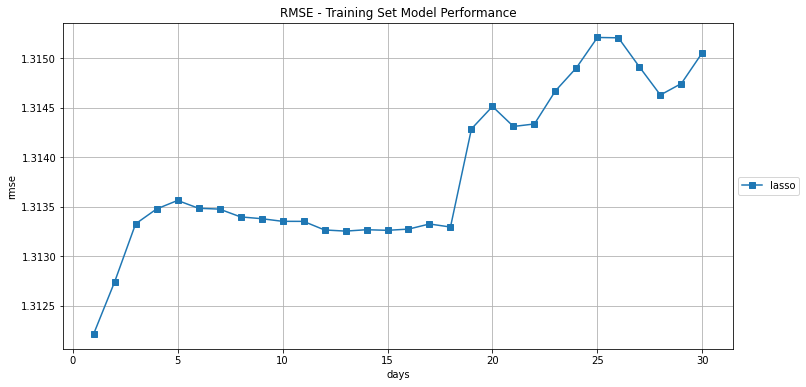

In [79]:
# plotting results
legend_list = []

for name, model in models.items():
    legend_list.append(name)
    plot_results(train_rmse_results[name])
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))

<h5>Predicting with validation set</h5>

In [80]:
valid_predictions = {}
valid_rmse_results = {}

for model in models:
    valid_predictions[model] = {}
    
for name, model in models.items():

    valid_results = run_model(model, X_train_scaled, y_train_scaled, X_valid_scaled, valid)
    valid_predictions[name] = valid_results
    valid_rmse_results[name] = rmse_scores(valid_predictions[name], y_valid)

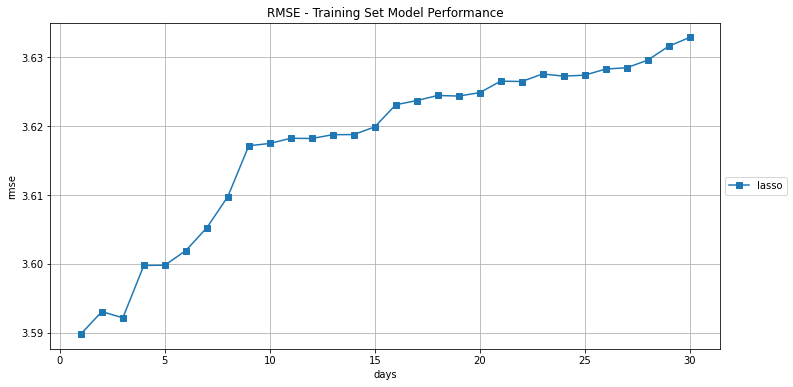

In [81]:
legend_list = []

for name, model in models.items():
    legend_list.append(name)
    plot_results(valid_rmse_results[name])
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))

In [115]:
# experimenting with different params
from sklearn.model_selection import GridSearchCV

lasso_params = {'alpah': [0.1, 1, 10],
                'tol': [0.0001, 0.001, 0.01]}
sgd_regressor_params = {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                        'penalty': ['l1', 'l2', 'elasticnet'],
                        'alpha': [0.00001, 0.0001, 0.001, 0.01],
                        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']}
svr_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.01, 0.05, 0.1, 0.2]}
xgb_params = {
#             'n_estimators': [10, 50, 100],
#               'max_depth': [3, 6, 9],
#               'learning_rate': [0.1, 1],
#               'gamma': [0.0, 1.0, 2.0],
#               'reg_alpha': [0, 150, 300, 500],
#               'min_child_weight': [1, 5, 10],
#                 'colsample_bytree': [0.1, 0.2, 0.5],
#               'subsample': [0.1, 0.2, 0.5]
            }
# max_depth=3, min_child_weight=10, colsample_bytree=0.2, subsample=0.2


grid = GridSearchCV(models['xgb_regressor'], xgb_params, scoring='neg_mean_squared_error')

param_results = {}
for day in range(1, 11):
    grid_results = grid.fit(X_train_scaled, y_train_scaled[f'SPY_target_{day}d'])
    param_results[day] = grid_results.best_params_
param_results

{1: {'colsample_bytree': 0.5, 'subsample': 0.2},
 2: {'colsample_bytree': 0.2, 'subsample': 0.5},
 3: {'colsample_bytree': 0.5, 'subsample': 0.1},
 4: {'colsample_bytree': 0.5, 'subsample': 0.2},
 5: {'colsample_bytree': 0.2, 'subsample': 0.2},
 6: {'colsample_bytree': 0.2, 'subsample': 0.1},
 7: {'colsample_bytree': 0.5, 'subsample': 0.1},
 8: {'colsample_bytree': 0.2, 'subsample': 0.5},
 9: {'colsample_bytree': 0.2, 'subsample': 0.2},
 10: {'colsample_bytree': 0.2, 'subsample': 0.5}}

<h5>Predicting with test set</h5>

In [45]:
test_results = pd.Series()
y_train_valid_scaled_day = list(y_train_valid_scaled['SPY_target_1d'])

for day in range(1, days_to_predict):
    X_test_scaled = (X_test - test[f'SPY_mean_{day}d']) / test[f'SPY_std_{day}d']
    X_test_scaled = X_test_scaled.values.reshape(1,-1)
    
    model.fit(np.array(X_train_valid_scaled), y_train_valid_scaled_day)
    predictions = model.predict(X_test_scaled)
    
    inversed_scaled_predictions = predictions * test[f'SPY_std_{day}d'] + test[f'SPY_mean_{day}d']
    test_results[f'SPY_target_{day}d'] = float(inversed_scaled_predictions[0])

    next_day_targets = list(y_train_valid_scaled[f'SPY_target_{day+1}d'].iloc[:-1])
    next_day_targets.append(predictions[0])
    y_train_valid_scaled_day = next_day_targets

/Users/terrill/OneDrive/Documents/work/projects/spy/venv_spy/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [46]:
test_rmse_score = math.sqrt(mean_squared_error(actual_results['SPY_target_1d'], test_results))
test_rmse_score

3.309220358696652

Text(0.5, 1.0, 'Test Predictions')

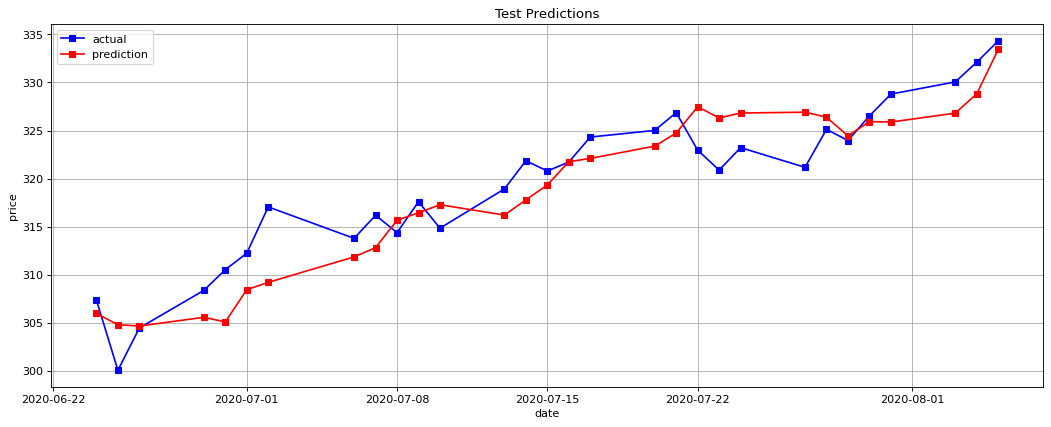

In [47]:
# plot the rmse results and the predictions/actual data
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

plt.plot(actual_results.index, actual_results['SPY_target_1d'], color='b', marker='s')
plt.plot(actual_results.index, test_results, color='r', marker='s')

plt.grid()
plt.legend(['actual', 'prediction'])
plt.xlabel('date')
plt.ylabel('price')
plt.title('Test Predictions')

Final 30 day predictions RSME: 6.65.

There is a slight lag in predictions, especially during major reversals of the market.

For this iteration I created a 30 day prediction using the direct multi-step forecast strategy.

This analysis excludes the DIX and GEX index.

After making a few minor tuning to the parameters of each model I was able to slightly improve performance but overall performance did not improve. The Lasso model continued to outperform the rest of the algorithms even without parameter tuning. Note, parameters used for XGBoost model was pulled from previous iterations that contained more in-depth tuning.


The next steps to improving this model:
- predict the next 15/30 days using recursive strategy
- break out each financial feature groups and filter out the low performing ones
- feature engineering (add industry ticker data and volume, % change, etc.)
- explore other scaling methods

To do list:
- write scripts that will continuously upload new data into server
- explore adding options data if possible
- try DNN models (tensorflow) 

In [ ]:
# You could try predicting them.
# You could try padding with zeros.
# You could try persisting the last values.
# You could try using a direct method instead.
# https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

# removed CPI and all current futures, added crude_oil_wti from another data source

# check why the consecutive targets don't match when shifting?
# should we scale the data then shift the targets?